
Going thorugh the docs: https://github.com/GouMinghao/rgb_matters/blob/main/docs/label_vis.png

When I run: python3 /home/bam/public_ws/src/rgb_matters/vis_label.py

I see very strange results! 

One hope is that the image in the documentation seems a bit off as well:
https://github.com/GouMinghao/rgb_matters/blob/main/docs/label_vis.png

Another reason is that in the `get_z` function it does an average over a grid in the depth camera, + 1 std..

replacing it with just directly looking up gives a much much more sesible result. The frame is better the fingers? or at the center, cnot sure but either way it looks reaosnable

```python
    z = get_z(depths, grid_x, grid_y, 1) 
    z = depths[pixel_y, pixel_x] # use a simpler method to get the z
```


<img src="/home/bam/public_ws/src/rgb_matters/dev/imgs/label_vis.png" style="max-width:500px">


How do I know that the labels are correct? Idea is to view as heat map, as the 3D viz is illdefined.

- Having update the z depth, the labels now look much more reasonable
- I can also check the heatmaps. in determine_four_dof_channels.ipynb I figured out that 0 is the most up right and 0-4 (views) are all reasonable upright or 0-29 once you account for in in angle rotation, as you go from 0 - 360 it goes more down

To create a z map I can just keep the first 5..? or sum together the same in axis rotation accross the first 0-4 views



In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
# Yuck its such a mess to get these libraries working... right now I install both with pip and colcon... that seems to do the trick. I install them both in editable way... It should handle the overlay ok.

from rgb_matters.data.utils.label_loader import LabelLoader
from rgb_matters.data.utils.vis_label import vis_grasp, vis_grasp_view_angle
from rgb_matters.constant import GRASPNET_ROOT, LABEL_DIR

from graspnetAPI.utils.eval_utils import transform_points, create_table_points
from graspnetAPI.utils.utils import generate_scene_model

from graspnetAPI import GraspNet, GraspNetEval
import numpy as np
import matplotlib.pyplot as plt
import open3d as o3d
import cv2

# from bam_utils.heatmap_helper import show_heatmap_img, show_heatmap_img_grid

In [3]:
camera = "realsense"
g = GraspNetEval(root=GRASPNET_ROOT, camera=camera, split="all")

Loading data path...:   0%|          | 0/190 [00:00<?, ?it/s]

Loading data path...: 100%|██████████| 190/190 [00:00<00:00, 787.38it/s]


In [4]:
# Load in data and check dimensions
scene_id = 10
ann_id = 1

label_loader = LabelLoader(LABEL_DIR)
label = label_loader.load_label(
    scene_id=scene_id, camera=camera, ann_id=ann_id
)

label_img = np.transpose(label, (1, 2, 0))

print(label.shape)
print(label_img.shape)



color = g.loadRGB(scene_id, camera, ann_id)
depth = g.loadDepth(scene_id, camera, ann_id)
mask = g.loadMask(scene_id, camera, ann_id)

print(color.shape)
print(depth.shape)
print(mask.shape)

# TODO figure out

FileNotFoundError: [Errno 2] No such file or directory: '/home/bam/public_ws/src/rgb_matters/gen_data/rgbd_labels/scene_0010/realsense/0001.npy'

In [5]:
scene_pc = g.loadScenePointCloud(sceneId=scene_id, annId=ann_id, camera=camera)
obj_model_list = generate_scene_model(g.root, 'scene_%04d' % scene_id , ann_id, return_poses=False, align=False, camera=camera)

table = create_table_points(1.0, 1.0, 0.05, dx=-0.5, dy=-0.5, dz=-0.05, grid_size=0.008)
_, pose_list, camera_pose, align_mat = g.get_model_poses(scene_id, ann_id)
table_trans = transform_points(table, np.linalg.inv(np.matmul(align_mat, camera_pose)))
table_model = o3d.geometry.PointCloud()
table_model.points = o3d.utility.Vector3dVector(table_trans)


Scene scene_0010, realsense


In [6]:
vis_grasp(
    label,
    scene_id,
    camera,
    ann_id,
    show=True,
    graspnet_root=GRASPNET_ROOT,
    other_geometries=[*obj_model_list],
)

NameError: name 'label' is not defined

In [40]:
vis_grasp_view_angle(
    view_mask=[46],
    # angle_mask=[0, 1, 2, 3, 4, 5],
    angle_mask=[5],
    label=label,
    scene_id=scene_id,
    camera=camera,
    ann_id=ann_id,
    graspnet_root=GRASPNET_ROOT,
    other_geometries=[*obj_model_list],

)

Loading data path...: 100%|██████████| 190/190 [00:00<00:00, 718.04it/s]


Total Grasp:14


In [9]:
# Determine how to upscale the label to the orginal image size

print("Image to Resnet Input Downscale")
print(720/288)
print(1280/384)

print("Resnet Input to Output Downscale")
print(288/72)
print(384/96)

print(72 * 2.5 * 4)
print(96 * 3.3333333333333 * 4)

H_SCALE = 2.5 * 4
W_SCALE = 3.3333333333333 * 4

print(H_SCALE)
print(W_SCALE)

print(H_SCALE * 72)
print(W_SCALE * 96)


Image to Resnet Input Downscale
2.5
3.3333333333333335
Resnet Input to Output Downscale
4.0
4.0
720.0
1279.9999999999873
10.0
13.3333333333332
720.0
1279.9999999999873


In [10]:
print(type(label))
print(label.shape)

C, H, W = label.shape

print(C, H, W)

<class 'numpy.ndarray'>
(360, 72, 96)
360 72 96


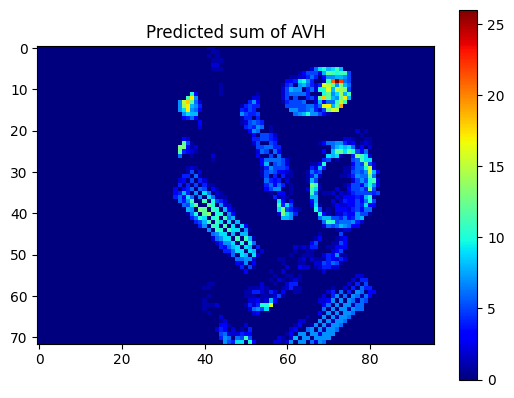

In [32]:
plt.title("Predicted sum of AVH")
pred_heatmap = np.sum(label, axis=0)
# pred_heatmap = pred_heatmap / pred_heatmap.max()
plt.imshow(pred_heatmap, cmap="jet")
plt.colorbar()
plt.show()

In [33]:
# Actually they already have a clean way to calculate the upscale factor

from rgb_matters.data.utils.transformation import (
    NUM_GRID_X,
    NUM_GRID_Y,
    X_LENGTH,
    Y_LENGTH,
    get_z,
    framexy_depth_2_xyz,
)

X_STEP = X_LENGTH / NUM_GRID_X
Y_STEP = Y_LENGTH / NUM_GRID_Y

print(X_STEP)
print(Y_STEP)

print(X_STEP * 96)
print(Y_STEP * 72)

13.333333333333334
10.0
1280.0
720.0


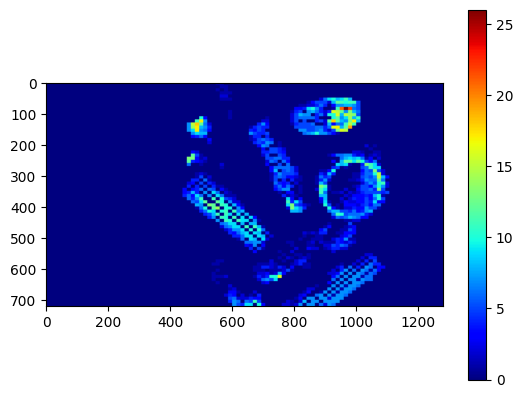

In [34]:
# Suppose heatmap is your 2D numpy array (dtype float32/float64, values 0–1 or 0–255)
upsampled = cv2.resize(
    pred_heatmap, 
    (1280, 720), 
    interpolation=cv2.INTER_NEAREST  # or INTER_LINEAR / INTER_CUBIC depending on your needs
)

plt.imshow(upsampled, cmap="jet")
plt.colorbar()
plt.show()

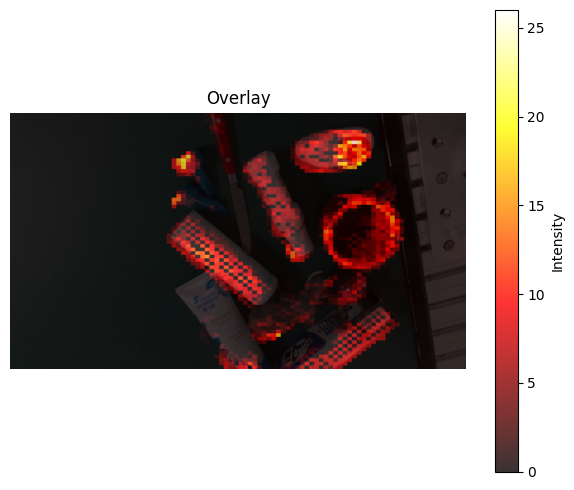

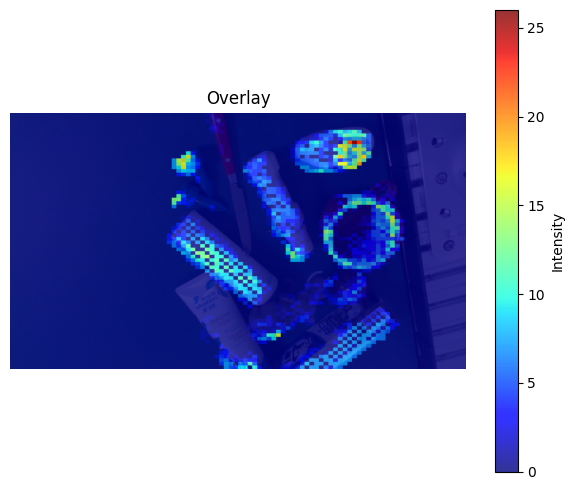

In [35]:
show_heatmap_img(color, upsampled, alpha=0.8, cmap="hot")
show_heatmap_img(color, upsampled, alpha=0.8, cmap="jet")

In [36]:
def shortest_angle_between_vectors(v1, v2):
    v1 = np.asarray(v1)
    v2 = np.asarray(v2)
    # Normalize the vectors
    v1_norm = v1 / np.linalg.norm(v1)
    v2_norm = v2 / np.linalg.norm(v2)
    # Compute the dot product and clamp to [-1, 1] to avoid numerical issues
    dot_product = np.clip(np.dot(v1_norm, v2_norm), -1.0, 1.0)
    angle = np.arccos(dot_product)
    return angle

channel: 0, view: 0, angle: 0
channel: 1, view: 0, angle: 1
channel: 2, view: 0, angle: 2
channel: 3, view: 0, angle: 3
channel: 4, view: 0, angle: 4
channel: 5, view: 0, angle: 5
channel: 6, view: 1, angle: 0
channel: 7, view: 1, angle: 1
channel: 8, view: 1, angle: 2
channel: 9, view: 1, angle: 3
channel: 10, view: 1, angle: 4
channel: 11, view: 1, angle: 5
channel: 12, view: 2, angle: 0
channel: 13, view: 2, angle: 1
channel: 14, view: 2, angle: 2
channel: 15, view: 2, angle: 3
channel: 16, view: 2, angle: 4
channel: 17, view: 2, angle: 5
channel: 18, view: 3, angle: 0
channel: 19, view: 3, angle: 1
channel: 20, view: 3, angle: 2
channel: 21, view: 3, angle: 3
channel: 22, view: 3, angle: 4
channel: 23, view: 3, angle: 5
channel: 24, view: 4, angle: 0
channel: 25, view: 4, angle: 1
channel: 26, view: 4, angle: 2
channel: 27, view: 4, angle: 3
channel: 28, view: 4, angle: 4
channel: 29, view: 4, angle: 5
channel: 30, view: 5, angle: 0
channel: 31, view: 5, angle: 1
channel: 32, view:

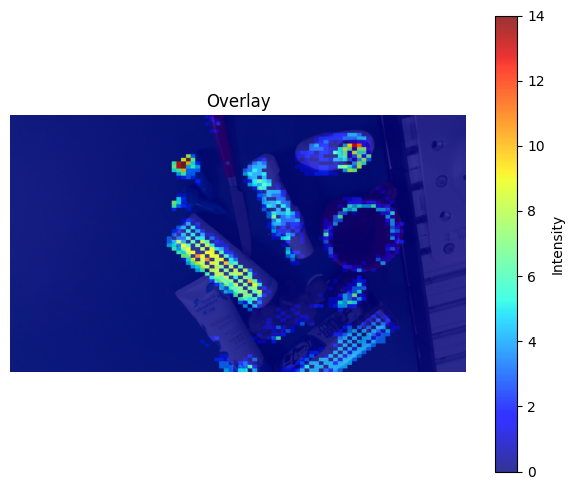

New height:  360
New width:  640
base_height: 2
View vector:  [ 0.12883016  0.         -0.9916667 ]
x0, y0:  320.0 180.0
x1, y1:  340.87048667669296 180.0
View vector:  [ 0.12883016  0.         -0.9916667 ]
x0, y0:  320.0 180.0
x1, y1:  340.87048667669296 180.0
View vector:  [ 0.12883016  0.         -0.9916667 ]
x0, y0:  320.0 180.0
x1, y1:  340.87048667669296 180.0
View vector:  [ 0.12883016  0.         -0.9916667 ]
x0, y0:  320.0 180.0
x1, y1:  340.87048667669296 180.0
View vector:  [ 0.12883016  0.         -0.9916667 ]
x0, y0:  320.0 180.0
x1, y1:  340.87048667669296 180.0
View vector:  [ 0.12883016  0.         -0.9916667 ]
x0, y0:  320.0 180.0
x1, y1:  340.87048667669296 180.0
View vector:  [-0.1638468  -0.15009716 -0.975     ]
x0, y0:  320.0 180.0
x1, y1:  293.4568174779415 155.68425983190536
View vector:  [-0.1638468  -0.15009716 -0.975     ]
x0, y0:  320.0 180.0
x1, y1:  293.4568174779415 155.68425983190536
View vector:  [-0.1638468  -0.15009716 -0.975     ]
x0, y0:  320.0 180.0

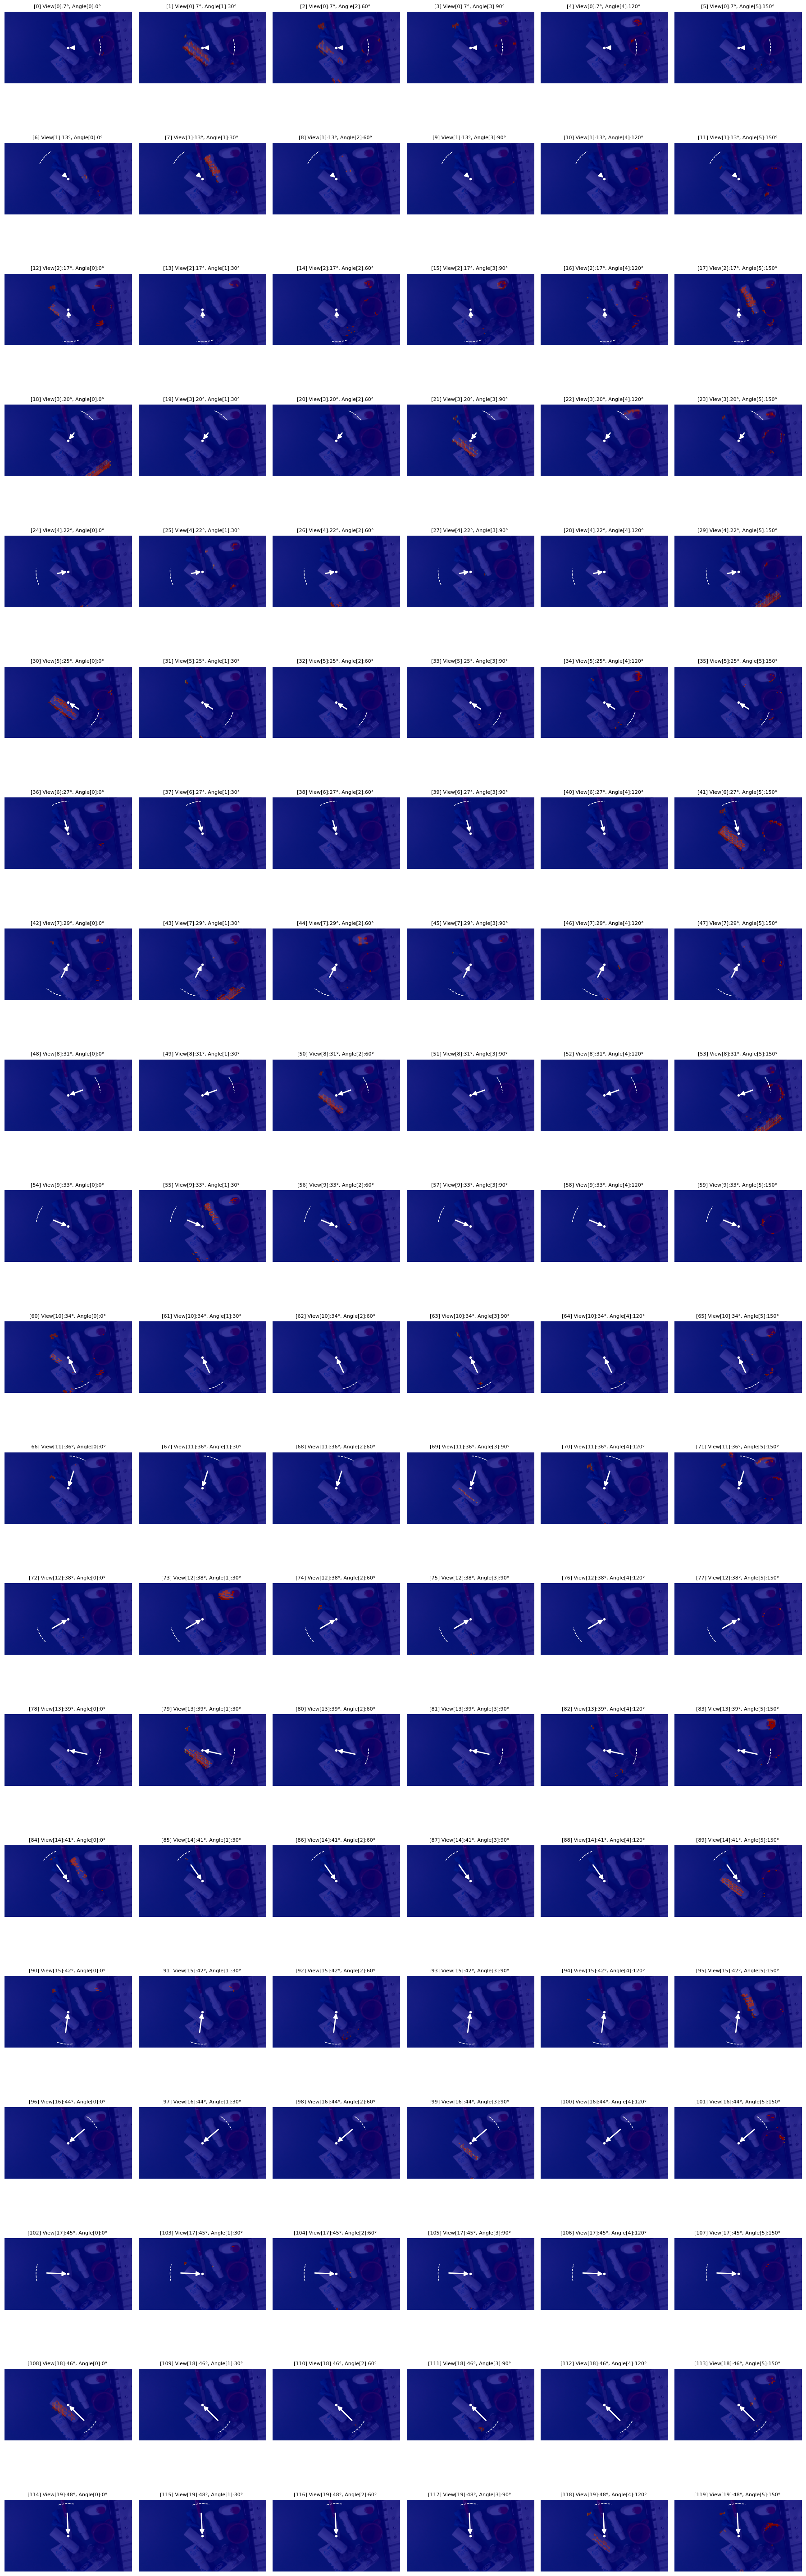

In [44]:
from rgb_matters.data.utils.convert import decode_view_angle_index
from rgb_matters.data.utils.generate_anchor_matrix import NUM_VIEWS, NUM_ANGLES
from rgb_matters.data.utils.generate_anchor_matrix import generate_matrix, generate_views, generate_angles

first_n_views = 20
first_n_channels = first_n_views * NUM_ANGLES
view_angle_pairs = decode_view_angle_index(np.arange(first_n_channels))
for i, (view, angle) in enumerate(view_angle_pairs):
    print(f"channel: {i}, view: {view}, angle: {angle}")

# Now we can use this to get the channels we want to visualize
print(label.shape)
z_label = label[:first_n_channels, :, :]
print(z_label.shape)
z_label_img = z_label.transpose(1, 2, 0)
print(z_label_img.shape)
assert np.allclose(np.sum(z_label, axis=0), np.sum(z_label_img, axis=2))


us_z_label_img = cv2.resize(
    np.float32(z_label_img), 
    (1280, 720), 
    interpolation=cv2.INTER_NEAREST  # or INTER_LINEAR / INTER_CUBIC depending on your needs
)


show_heatmap_img(color, us_z_label_img.sum(axis=2), alpha=0.8, cmap="jet")

ref_vec = np.array([0, 0, -1])
angles = generate_angles()
views = generate_views()

import numpy as np



# print(views)
# print(angles)

# hmm the angle is perhaps a bit misleading. mabye I can draw the vector?

title_list = []
for i, (view_idx, angle_idx) in enumerate(view_angle_pairs):
    view_vec = views[view_idx]
    view_angle = shortest_angle_between_vectors(ref_vec, view_vec)

    title_list.append(f"[{i}] View[{view_idx}]:{int(round(np.rad2deg(view_angle)))}°, Angle[{angle_idx}]:{int(round(np.rad2deg(angles[angle_idx])))}° ")



downsample_factor = 2
fig, axes = show_heatmap_img_grid(color, us_z_label_img, rows=min(first_n_views,60), cols=6, alpha=0.8, title_list=title_list, cmap="jet", show=False, return_fig_axes=True, downsample_factor=downsample_factor)


from matplotlib.patches import FancyArrowPatch, Circle, Arc

H, W = us_z_label_img.shape[:2]
H = H // downsample_factor
W = W // downsample_factor
cx, cy = W / 2.0, H / 2.0
radius = 0.45 * min(W, H)  # arrow length as a fraction of the image size

# Only draw for the panels we actually rendered
pairs_to_draw = view_angle_pairs[: len(axes)]

for ax, (view_idx, _) in zip(axes, pairs_to_draw):
    v = views[view_idx]          # 3D direction (x, y, z)
    print("View vector: ", v)
    p = np.array([v[0], v[1]])   # project to XY plane

    # Skip (or draw a dot) if the XY projection is tiny
    n = np.linalg.norm(p)
    if n < 1e-8:
        ax.add_patch(FancyArrowPatch((cx, cy), (cx, cy),
                                     arrowstyle='o', mutation_scale=8,
                                     linewidth=1.5, color='white'))
        continue

    # p = p / n  # unit XY direction
    # don't normalize it!!! we want it to be based with z normal

    # Image coords: x to the right, y downward. We want +y (world) to point UP on the image,
    # so we invert the y component when mapping to image coordinates.
    x0, y0 = cx, cy
    x1 = cx + p[0] * radius
    y1 = cy + p[1] * radius  
    print("x0, y0: ", x0, y0)
    print("x1, y1: ", x1, y1)

    ax.add_patch(
        FancyArrowPatch(
            # (x0, y0), (x1, y1),
            (x1, y1), (x0, y0), # flip around as view goes towards origin

            arrowstyle='-|>',
            mutation_scale=14,   # arrowhead size
            linewidth=2.0,
            color='white'
        )
    )

    # draw a thin circle at the center to indicate radius
    # circle = Circle((cx, cy), radius, 
    #                 edgecolor='white', facecolor='none', 
    #                 linewidth=1.0, linestyle='--')  # dashed for clarity
    # ax.add_patch(circle)


    # --- Add a 30° arc ---
    # Angle orientation in matplotlib is in *degrees counter-clockwise* from +x axis.
    # Compute arrow direction angle in degrees:
    angle_deg = np.degrees(np.arctan2(p[1], p[0]))

    arc = Arc(
        (cx, cy),
        2*radius, 2*radius,       # width, height (diameter in each dir)
        angle=0,                  # rotation of the ellipse axes
        theta1=angle_deg - 15,    # start angle
        theta2=angle_deg + 15,    # end angle
        color='white',
        linewidth=1.0,
        linestyle='--'
    )
    ax.add_patch(arc)



# (optional) make the center visible
for ax in axes:
    ax.plot([cx], [cy], marker='o', markersize=3, color='white')



plt.tight_layout()
plt.show()